<a href="https://colab.research.google.com/github/vit050587/Natural_Language_Processing/blob/master/sem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Инструменты для работы с языком

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Задача: классификация твитов по тональности

У нас есть датасет из твитов, про каждый указано, как он эмоционально окрашен: положительно или отрицательно. Задача: предсказывать эмоциональную окраску.

Скачиваем куски датасета ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [5]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Natural_Language_Processing/Lesson02/positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Natural_Language_Processing/Lesson02/positive.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

<ipython-input-5-4e142422f4eb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = positive.append(negative)


In [6]:
df.tail()

,text,label
114906,"Спала в родительском доме, на своей кровати......",negative
114907,RT @jebesilofyt: Эх... Мы немного решили сокра...,negative
114908,"Что происходит со мной, когда в эфире #proacti...",negative
114909,"""Любимая,я подарю тебе эту звезду..."" Имя како...",negative
114910,@Ma_che_rie посмотри #непытайтесьпокинутьомск ...,negative


In [7]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

## Baseline: классификация необработанных n-грамм

### Векторизаторы

In [8]:
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer

Что такое n-граммы:

In [9]:
from nltk import ngrams

In [10]:
sent = 'Если б мне платили каждый раз'.split()
list(ngrams(sent, 1)) # униграммы

[('Если',), ('б',), ('мне',), ('платили',), ('каждый',), ('раз',)]

In [11]:
list(ngrams(sent, 2)) # биграммы

[('Если', 'б'),
 ('б', 'мне'),
 ('мне', 'платили'),
 ('платили', 'каждый'),
 ('каждый', 'раз')]

In [12]:
list(ngrams(sent, 3)) # триграммы

[('Если', 'б', 'мне'),
 ('б', 'мне', 'платили'),
 ('мне', 'платили', 'каждый'),
 ('платили', 'каждый', 'раз')]

In [13]:
list(ngrams(sent, 5)) # ... пентаграммы?

[('Если', 'б', 'мне', 'платили', 'каждый'),
 ('б', 'мне', 'платили', 'каждый', 'раз')]

Самый простой способ извлечь фичи из текстовых данных -- векторизаторы: `CountVectorizer` и `TfidfVectorizer`

Объект `CountVectorizer` делает простую вещь:
* строит для каждого документа (каждой пришедшей ему строки) вектор размерности `n`, где `n` -- количество слов или n-грам во всём корпусе
* заполняет каждый i-тый элемент количеством вхождений слова в данный документ

In [14]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train) # bow -- bag of words (мешок слов)

ngram_range отвечает за то, какие n-граммы мы используем в качестве фичей:<br/>
ngram_range=(1, 1) -- униграммы<br/>
ngram_range=(3, 3) -- триграммы<br/>
ngram_range=(1, 3) -- униграммы, биграммы и триграммы.

В vec.vocabulary_ лежит словарь: мэппинг слов к их индексам:

In [15]:
list(vec.vocabulary_.items())[:10]

[('22', 1552),
 ('уххх', 180554),
 ('какой', 111440),
 ('насыщенный', 129225),
 ('день', 97171),
 ('добро', 98655),
 ('зло', 107793),
 ('всё', 90298),
 ('чип', 186738),
 ('дейл', 96853)]

In [16]:
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [17]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.17      0.16      0.17     29000
    positive       0.16      0.16      0.16     28456

    accuracy                           0.16     57456
   macro avg       0.16      0.16      0.16     57456
weighted avg       0.16      0.16      0.16     57456



Попробуем сделать то же самое для триграмм:

In [18]:
vec = CountVectorizer(ngram_range=(3, 3))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.20      0.18      0.19     32856
    positive       0.06      0.07      0.07     24600

    accuracy                           0.13     57456
   macro avg       0.13      0.12      0.13     57456
weighted avg       0.14      0.13      0.14     57456



(как вы думаете, почему в результатах теперь такой разброс по сравнению с униграммами?)

## TF-IDF векторизация

`TfidfVectorizer` делает то же, что и `CountVectorizer`, но в качестве значений – tf-idf каждого слова.

Как считается tf-idf:

TF (term frequency) – относительная частотность слова в документе:
$$ TF(t,d) = \frac{n_t}{\sum_k n_k} $$

`t` -- слово (term), `d` -- документ, $n_t$ -- количество вхождений слова, $n_k$ -- количество вхождений остальных слов

IDF (inverse document frequency) – обратная частота документов, в которых есть это слово:
$$ IDF(t, D) = \mbox{log} \frac{|D|}{|{d : t \in d}|} $$

`t` -- слово (term), `D` -- коллекция документов

Перемножаем их:
$$TFIDF_(t,d,D) = TF(t,d) \times IDF(i, D)$$

Сакральный смысл – если слово часто встречается в одном документе, но в целом по корпусу встречается в небольшом
количестве документов, у него высокий TF-IDF.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.18      0.18      0.18     29107
    positive       0.17      0.18      0.17     28349

    accuracy                           0.18     57456
   macro avg       0.18      0.18      0.18     57456
weighted avg       0.18      0.18      0.18     57456



В этот раз получилось хуже :( Вернёмся к `CountVectorizer`.

## PMI

Можно оценить взаимосвязь слов в корпусе и понять, какие биграммы наиболее часто встречаются в тексте. Для этого можно использовать метрику PMI (Pointwise Mutual Information) - поточечная взаимная информация. Метрика PMI для двух слов вычисляется по формуле:

$$pmi(x; y) = log \frac{p(x,y)}{p(x)p(y)} $$

Здесь p(y|x) - вероятность встретить слово $y$ после $x$, $p(y)$ - вероятность встретить слово $y$.

Оценим важность биграмм в нашем обучающем корпусе.

In [22]:
import nltk

In [24]:
from nltk import collocations
nltk.download('genesis')
nltk.download('punkt')
print(type(nltk.corpus.genesis.words('english-web.txt')))
bigram_measures = collocations.BigramAssocMeasures()
# bigram_finder.apply_freq_filter(5)
bigram_finder = collocations.BigramCollocationFinder.from_documents([nltk.word_tokenize(x) for x in x_train])
bigrams = bigram_finder.nbest(bigram_measures.pmi, 100)
print(bigrams)

[nltk_data] Downloading package genesis to /root/nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


<class 'nltk.corpus.reader.util.StreamBackedCorpusView'>
[('+1239', '728'), ('+погода', 'крутая='), ('-Вам', 'завернуть'), ('-ДОВАЙТИ', 'АЛДСКУЛ'), ('-Зелено-карие', '-Киллджой'), ('-Киллджой', '-Котик'), ('-Корнейчук', 'затроллила'), ('-МАРИЯ', '-МИША'), ('-Маладец', '-Лол'), ('-Мамаааа', 'поправь'), ('-НЕ', 'БОЙЙСЯ'), ('-ОЗВУЧИВАТЕЛЬ', 'МУЛЬТИКОВ'), ('-САРА', '-ГОЛУБЫЕ'), ('-Я.банан', '-ахх'), ('-анал', '-абстиненция'), ('-г', 'үзээ'), ('-дайте', 'winston'), ('-иногда', '.Ностальгирую'), ('-купи', 'куру'), ('-мега', 'шизофреничная'), ('-наш', 'класс^^'), ('-он', 'выыыыыыыыыыыыыыыхоооооооооооооооодноооооооооооооооооооооооой'), ('-патлатые', '-лысый'), ('-раз', 'плёткой'), ('-умильного', 'львенка'), ('-что-то', 'неописуемое'), ('.................', 'Анникабрь'), ('.NET', 'языки.'), ('.Вы', 'ахуеете'), ('.выражаешься', '.то'), ('.нормально', 'так-/'), ('//t.co/2CJpfoet5W', 'любоп…'), ('//t.co/9SBGpdgVnd', 'Освещение'), ('//t.co/9pQlB7y2nj', 'Секундочку'), ('//t.co/BwHqij5zHM', 'аплоап')

Можно рассмотреть другие метрики оценки важности биграмм, например, метрику правдоподобия (подробнее про вычисление метрики можно посмотреть [здесь (пункт 5.3.4)](http://www.corpus.unam.mx/cursoenah/ManningSchutze_1999_FoundationsofStatisticalNaturalLanguageProcessing.pdf):

In [25]:
bigrams = bigram_finder.nbest(bigram_measures.likelihood_ratio, 100)
print(bigrams)

[(')', ')'), ('http', ':'), ('RT', '@'), (':', 'D'), ('!', '!'), (',', 'что'), (')', 'http'), ('у', 'меня'), (',', 'а'), (',', ')'), (')', ','), ('*', '*'), ('@', ')'), (':', ')'), (',', 'но'), (';', ')'), (')', ':'), (':', '*'), (':', '-'), ('у', 'нас'), (')', '@'), (',', ':'), (':', ','), ('@', ':'), (',', ','), (':', ':'), ('&', 'lt'), ('=', ')'), ('@', '@'), (':', 'DD'), ('-', ')'), (',', '@'), ('у', 'тебя'), ('lt', ';'), ('со', 'мной'), ('Доброе', 'утро'), ('и', ')'), (')', '!'), ('D', 'http'), (',', 'когда'), ('?', '?'), ('не', ')'), ('в', ')'), ('с', 'тобой'), ('новый', 'год'), (',', 'как'), ('#', 'євромайдан'), (',', 'я'), ('&', 'gt'), ('потому', 'что'), ('?', '—'), ('не', 'знаю'), (':', '-D'), ('У', 'меня'), ('все', 'равно'), ('RT', ')'), ('сих', 'пор'), ('самом', 'деле'), ('--', '--'), ('я', ')'), (':', 'DDD'), ('х', ')'), (',', 'чтобы'), (':', '!'), ('а', 'я'), (',', '!'), ('gt', ';'), (')', '#'), ('днем', 'рождения'), (')', '.'), ('об', 'этом'), ('!', ','), (';', '3'), (')'

Как можно заметить, немаловажную роль в текстах занимает пунктуация.

## Стоп-слова и пунктуация

*Стоп-слова* -- это слова, которые часто встречаются практически в любом тексте и ничего интересного не говорят о конретном документе, то есть играют роль шума. Поэтому их принято убирать. По той же причине убирают и пунктуацию.

In [26]:
# у вас здесь, вероятно, выскочит ошибка и надо будет загрузить стоп слова (в тексте ошибки написано, как)
from nltk.corpus import stopwords
nltk.download('stopwords')
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [28]:
noise = stopwords.words('russian') + list(punctuation)

В векторизаторах за стоп-слова, логичным образом, отвечает аргумент `stop_words`.

In [30]:
from nltk.tokenize import word_tokenize

In [31]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.15      0.15      0.15     28547
    positive       0.16      0.16      0.16     28909

    accuracy                           0.16     57456
   macro avg       0.16      0.16      0.16     57456
weighted avg       0.16      0.16      0.16     57456



Получилось чуть лучше. Что ещё можно сделать?

## Лемматизация

Лемматизация – это сведение разных форм одного слова к начальной форме – *лемме*. Почему это хорошо?
* Во-первых, мы хотим рассматривать как отдельную фичу каждое *слово*, а не каждую его отдельную форму.
* Во-вторых, некоторые стоп-слова стоят только в начальной форме, и без лематизации выкидываем мы только её.

Для русского есть два хороших лемматизатора: mystem и pymorphy:

### [Mystem](https://tech.yandex.ru/mystem/)
Как с ним работать:
* можно скачать mystem и запускать [из терминала с разными параметрами](https://tech.yandex.ru/mystem/doc/)
* [pymystem3](https://pythonhosted.org/pymystem3/pymystem3.html) - обертка для питона, работает медленнее, но это удобно

In [32]:
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /bin

--2023-07-01 19:08:28--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.244, 5.45.205.245, 5.45.205.241, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.244|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cachev2-spb01.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=122 [following]
--2023-07-01 19:08:29--  http://cachev2-spb01.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=122
Resolving cachev2-spb01.cdn.yandex.net (cachev2-spb01.cdn.yandex.net)... 37.9.93.112, 2a02:6b8:117:5::112
Connecting to cachev2-spb01.cdn.yandex.net (cachev2-spb01.cdn.yandex.net)|37.9.93.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz’

mystem-3.0-linux3.1 100%[========

In [33]:
from pymystem3 import Mystem
mystem_analyzer = Mystem()

Мы инициализировали Mystem c дефолтными параметрами. А вообще параметры есть такие:
* mystem_bin - путь к `mystem`, если их несколько
* grammar_info - нужна ли грамматическая информация или только леммы (по дефолту нужна)
* disambiguation - нужно ли снятие омонимии - дизамбигуация (по дефолту нужна)
* entire_input - нужно ли сохранять в выводе все (пробелы всякие, например), или можно выкинуть (по дефолту оставляется все)

Методы Mystem принимают строку, токенизатор вшит внутри. Можно, конечно, и пословно анализировать, но тогда он не сможет учитывать контекст.

Можно просто лемматизировать текст:

In [34]:
#print(mystem_analyzer.lemmatize(example))

NameError: ignored

А можно получить грамматическую информацию:

In [ ]:
#mystem_analyzer.analyze(example)

Давайте терепь используем лемматизатор майстема в качестве токенизатора.

In [35]:
import re
def my_preproc(text):
    text = re.sub('[{}]'.format(punctuation), '', text)
    text = mystem_analyzer.lemmatize(text)
    return [word for word in text if word not in stopwords.words('russian') + [' ', '\n']]

In [36]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=my_preproc)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.17      0.17      0.17     28959
    positive       0.16      0.17      0.16     28497

    accuracy                           0.17     57456
   macro avg       0.17      0.17      0.17     57456
weighted avg       0.17      0.17      0.17     57456



### [Pymorphy](http://pymorphy2.readthedocs.io/en/latest/)
Это модуль на питоне, довольно быстрый и с кучей функций.

In [37]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 63.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=50e3376340beba488aef0f776407656e89abac312f431d869a4eae37345e4774
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [38]:
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

pymorphy2 работает с отдельными словами. Если дать ему на вход предложение - он его просто не лемматизирует, т.к. не понимает

In [39]:
ana = pymorphy2_analyzer.parse(sent[3])
ana

[Parse(word='платили', tag=OpencorporaTag('VERB,impf,tran plur,past,indc'), normal_form='платить', score=1.0, methods_stack=((DictionaryAnalyzer(), 'платили', 2472, 10),))]

In [40]:
ana[0].normal_form

'платить'

### [Natasha](https://github.com/natasha/)

В библиотеке natasha реализовано множество полезных библиотек для русского языка: разбиение на токены и предложения, русскоязычные word embeddings, морфологический, синтаксический анализ, лемматизация, извлечение именованных сущностей и т.д. Модуль библиотеки Razdel, основанный на правилах, предназначен для разбиения текста на токены и предложения.

In [41]:
!pip install razdel

In [42]:
from razdel import tokenize

tokens = list(tokenize('Кружка-термос на 0.5л (50/64 см³, 516;...)'))
tokens

[Substring(0, 13, 'Кружка-термос'),
 Substring(14, 16, 'на'),
 Substring(17, 20, '0.5'),
 Substring(20, 21, 'л'),
 Substring(22, 23, '('),
 Substring(23, 28, '50/64'),
 Substring(29, 32, 'см³'),
 Substring(32, 33, ','),
 Substring(34, 37, '516'),
 Substring(37, 38, ';'),
 Substring(38, 41, '...'),
 Substring(41, 42, ')')]

In [43]:
[_.text for _ in tokens]

['Кружка-термос',
 'на',
 '0.5',
 'л',
 '(',
 '50/64',
 'см³',
 ',',
 '516',
 ';',
 '...',
 ')']

In [44]:
!pip install natasha

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26099 sha256=94a3d36acd249404a60cecaa1348a1832f9d160cad1a74d40c0ccb33731892ec
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built intervaltree


С помощью библиотеки natasha можно также лемматизировать тексты.

In [45]:
from natasha import Doc, MorphVocab, Segmenter, NewsEmbedding, NewsMorphTagger

segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

def natasha_lemmatize(text):
  doc = Doc(text)
  doc.segment(segmenter)
  doc.tag_morph(morph_tagger)
  for token in doc.tokens:
    token.lemmatize(morph_vocab)
  return {_.text: _.lemma for _ in doc.tokens}

In [46]:
text = 'Посол Израиля на Украине Йоэль Лион признался, что пришел в шок, узнав о решении властей Львовской области объявить 2019 год годом лидера запрещенной в России Организации украинских националистов (ОУН) Степана Бандеры. Свое заявление он разместил в Twitter. «Я не могу понять, как прославление тех, кто непосредственно принимал участие в ужасных антисемитских преступлениях, помогает бороться с антисемитизмом и ксенофобией. Украина не должна забывать о преступлениях, совершенных против украинских евреев, и никоим образом не отмечать их через почитание их исполнителей», — написал дипломат. 11 декабря Львовский областной совет принял решение провозгласить 2019 год в регионе годом Степана Бандеры в связи с празднованием 110-летия со дня рождения лидера ОУН (Бандера родился 1 января 1909 года). В июле аналогичное решение принял Житомирский областной совет. В начале месяца с предложением к президенту страны Петру Порошенко вернуть Бандере звание Героя Украины обратились депутаты Верховной Рады. Парламентарии уверены, что признание Бандеры национальным героем поможет в борьбе с подрывной деятельностью против Украины в информационном поле, а также остановит «распространение мифов, созданных российской пропагандой». Степан Бандера (1909-1959) был одним из лидеров Организации украинских националистов, выступающей за создание независимого государства на территориях с украиноязычным населением. В 2010 году в период президентства Виктора Ющенко Бандера был посмертно признан Героем Украины, однако впоследствии это решение было отменено судом. '

natasha_lemmatize(text)

{'Посол': 'посол',
 'Израиля': 'израиль',
 'на': 'на',
 'Украине': 'украина',
 'Йоэль': 'йоэль',
 'Лион': 'лион',
 'признался': 'признаться',
 ',': ',',
 'что': 'что',
 'пришел': 'прийти',
 'в': 'в',
 'шок': 'шок',
 'узнав': 'узнать',
 'о': 'о',
 'решении': 'решение',
 'властей': 'власть',
 'Львовской': 'львовский',
 'области': 'область',
 'объявить': 'объявить',
 '2019': '2019',
 'год': 'год',
 'годом': 'год',
 'лидера': 'лидер',
 'запрещенной': 'запретить',
 'России': 'россия',
 'Организации': 'организация',
 'украинских': 'украинский',
 'националистов': 'националист',
 '(': '(',
 'ОУН': 'оун',
 ')': ')',
 'Степана': 'степан',
 'Бандеры': 'бандера',
 '.': '.',
 'Свое': 'свой',
 'заявление': 'заявление',
 'он': 'он',
 'разместил': 'разместить',
 'Twitter': 'twitter',
 '«': '«',
 'Я': 'я',
 'не': 'не',
 'могу': 'мочь',
 'понять': 'понять',
 'как': 'как',
 'прославление': 'прославление',
 'тех': 'тот',
 'кто': 'кто',
 'непосредственно': 'непосредственно',
 'принимал': 'принимать',
 'уча

### mystem vs. pymorphy vs. natasha

1) *Мы надеемся, что вы пользуетесь линуксом*, но mystem работает невероятно медленно под windows на больших текстах.

2) *Снятие омонимии*. Mystem умеет снимать омонимию по контексту (хотя не всегда преуспевает), pymorphy2 берет на вход одно слово и соответственно вообще не умеет дизамбигуировать по контексту, natasha тоже с этим тоже не справляется успешно:

In [47]:
homonym1 = 'За время обучения я прослушал больше сорока курсов.'
homonym2 = 'Сорока своровала блестящее украшение со стола.'

In [48]:
mystem_analyzer = Mystem() # инициализирую объект с дефолтными параметрами

print(mystem_analyzer.analyze(homonym1)[-5])
print(mystem_analyzer.analyze(homonym2)[0])

{'analysis': [{'lex': 'сорок', 'wt': 0.8710292578, 'gr': 'NUM=(пр|дат|род|твор)'}], 'text': 'сорока'}
{'analysis': [{'lex': 'сорока', 'wt': 0.1210970059, 'gr': 'S,жен,од=им,ед'}], 'text': 'Сорока'}


In [49]:
print(natasha_lemmatize(homonym1))

{'За': 'за', 'время': 'время', 'обучения': 'обучение', 'я': 'я', 'прослушал': 'прослушать', 'больше': 'большой', 'сорока': 'сорок', 'курсов': 'курс', '.': '.'}


In [50]:
print(natasha_lemmatize(homonym2))

{'Сорока': 'сорок', 'своровала': 'своровать', 'блестящее': 'блестящий', 'украшение': 'украшение', 'со': 'с', 'стола': 'стол', '.': '.'}


## Словарь, закон Ципфа и закон Хипса

Закон Ципфа -- эмпирическая закономерность: если все слова корпуса текста упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n. Иными словами, частотность слов убывает очень быстро.

In [51]:
from collections import Counter

In [52]:
corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

2993652


['first_timee', 'хоть', 'я', 'и', 'школота', 'но', 'поверь', 'у', 'нас', 'то']

In [53]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('и', 58672),
 ('не', 54862),
 ('в', 54194),
 ('я', 49296),
 ('http', 44944),
 ('RT', 44070),
 ('на', 37048),
 ('D', 33020),
 ('с', 30626),
 ('что', 30440)]

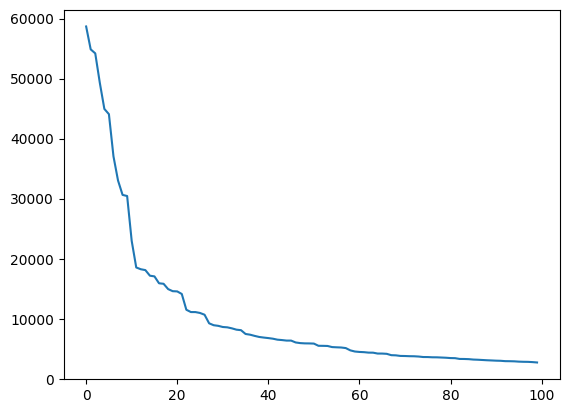

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
first_100_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.plot(first_100_freqs)
plt.show()

Закон Хипса -- обратная сторона закона Ципфа. Он описывает, что чем больше корпус, тем меньше новых слов добавляется с добавлением новых текстов. В какой-то момент корпус насыщается.

## Задание 1.

**Задание**: обучите три классификатора:

1) на токенах с высокой частотой

2) на токенах со средней частотой

3) на токенах с низкой частотой

Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

In [55]:
from nltk.corpus import stopwords
nltk.download('stopwords')
my_stopwords = stopwords.words('russian')
# noise = stopwords.words('russian') + list(punctuation)
noise = stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Natural_Language_Processing/Lesson02/positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Natural_Language_Processing/Lesson02/negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

<ipython-input-57-440f9aab0239>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = positive.append(negative)


In [58]:
df

,text,label
0,"@first_timee хоть я и школота, но поверь, у на...",positive
1,"Да, все-таки он немного похож на него. Но мой ...",positive
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,positive
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",positive
4,@irina_dyshkant Вот что значит страшилка :D\nН...,positive
...,...,...
111918,Но не каждый хочет что то исправлять:( http://...,negative
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative
111920,"Вот и в школу, в говно это идти уже надо(",negative
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative


In [59]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

In [60]:
def get_tokens_importance(maxdf, mindf):

    tfidf_vect = TfidfVectorizer(max_df=maxdf, # не берем слова что выше тресхолда
                                 min_df=mindf, # не берем что ниже тресхолда
#                                  max_features=1000,
#                                  stop_words=noise,
                                 )

    bow = tfidf_vect.fit_transform(x_train)
    clf = LogisticRegression(random_state=42)
    clf.fit(bow, y_train)

    pred = clf.predict(tfidf_vect.transform(x_test))
    print(f'max_df= {maxdf} min_df= {mindf}')
    print(classification_report(pred, y_test))

In [61]:
# Берем все токены - f1-score получается низкая
get_tokens_importance(1, 1)

max_df= 1 min_df= 1
              precision    recall  f1-score   support

    negative       0.90      0.53      0.66     47509
    positive       0.22      0.68      0.33      9200

    accuracy                           0.55     56709
   macro avg       0.56      0.60      0.50     56709
weighted avg       0.79      0.55      0.61     56709



In [62]:
# Берем токены часто встречающиеся
get_tokens_importance(1.0, 0.285)

max_df= 1.0 min_df= 0.285
              precision    recall  f1-score   support

    negative       0.35      0.60      0.44     16366
    positive       0.77      0.55      0.64     40343

    accuracy                           0.56     56709
   macro avg       0.56      0.57      0.54     56709
weighted avg       0.65      0.56      0.58     56709



In [63]:
# Берем токены средне встречающиеся
get_tokens_importance(0.7, 0.15)

max_df= 0.7 min_df= 0.15
              precision    recall  f1-score   support

    negative       0.35      0.60      0.44     16087
    positive       0.78      0.55      0.64     40622

    accuracy                           0.56     56709
   macro avg       0.56      0.58      0.54     56709
weighted avg       0.65      0.56      0.59     56709



In [64]:
# Берем токены низкочастотные
get_tokens_importance(0.3, 1)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


max_df= 0.3 min_df= 1
              precision    recall  f1-score   support

    negative       0.73      0.76      0.75     26883
    positive       0.78      0.75      0.76     29826

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



Судя по метрикам, низкочастотные токены наиболее важны для классификации

## О важности эксплоративного анализа

Но иногда пунктуация бывает и не шумом -- главное отталкиваться от задачи. Что будет если вообще не убирать пунктуацию?

In [65]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     28010
    positive       1.00      1.00      1.00     28699

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



Шок! Стоило оставить пунктуацию -- и все метрики равны 1. Как это получилось? Среди неё были очень значимые токены (как вы думаете, какие?). Найдите фичи с самыми большими коэффициэнтами:

## Задание 2.

найти фичи с наибольшей значимостью, и вывести их

In [66]:
from collections import Counter

In [67]:
# corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]
corpus = [token for tweet in df.text for token in word_tokenize(tweet)]
print(len(corpus))
corpus[:10]

4027088


['@', 'first_timee', 'хоть', 'я', 'и', 'школота', ',', 'но', 'поверь', ',']

In [68]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('(', 212404),
 (')', 194005),
 (',', 188295),
 (':', 177675),
 ('@', 149978),
 ('не', 69472),
 ('!', 66923),
 ('.', 57623),
 ('и', 55166),
 ('в', 52902)]

Посмотрим, как один из супер-значительных токенов справится с классификацией безо всякого машинного обучения:

In [70]:
cool_token = '!'
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.87      0.51      0.64     48263
    positive       0.17      0.57      0.26      8446

    accuracy                           0.52     56709
   macro avg       0.52      0.54      0.45     56709
weighted avg       0.77      0.52      0.58     56709



In [71]:
cool_token = ':'
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.49      0.55      0.52     24915
    positive       0.61      0.55      0.58     31794

    accuracy                           0.55     56709
   macro avg       0.55      0.55      0.55     56709
weighted avg       0.55      0.55      0.55     56709



In [72]:
cool_token = ')'
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      0.85      0.92     33041
    positive       0.83      1.00      0.90     23668

    accuracy                           0.91     56709
   macro avg       0.91      0.92      0.91     56709
weighted avg       0.93      0.91      0.91     56709



")" Это часть смайлика или сам смайлик - и его присутствие в твите в основном говорит о положительном твите и наоборот.

## Символьные n-граммы

Теперь в качестве фичей используем, например, униграммы символов:

In [73]:
vec = CountVectorizer(analyzer='char', ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.99      1.00      1.00     27942
    positive       1.00      0.99      1.00     28767

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



В общем-то, теперь уже понятно, почему на этих данных здесь 1. Так или инчае, на символах классифицировать тоже можно: для некторых задач (например, для определения языка) фичи-символьные n-граммы решительно рулят.

Ещё одна замечательная особенность фичей-символов: токенизация и лемматизация не нужна, можно использовать такой подход для языков, у которых нет готвых анализаторов.

### Задание 3.

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера

3) убедиться что для сетки нет переобучения

In [74]:
%%time

count_vect = CountVectorizer()
bow = count_vect.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

pred = clf.predict(count_vect.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.76      0.75      0.76     28352
    positive       0.76      0.76      0.76     28357

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709

CPU times: user 18.5 s, sys: 10.9 s, total: 29.5 s
Wall time: 21.4 s


In [75]:
%%time

tfidf_vect = TfidfVectorizer()
bow = tfidf_vect.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

pred = clf.predict(tfidf_vect.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.73      0.76      0.75     26883
    positive       0.78      0.75      0.76     29826

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709

CPU times: user 21.5 s, sys: 13.1 s, total: 34.5 s
Wall time: 25 s


In [80]:
from sklearn.feature_extraction.text import HashingVectorizer
import sklearn
from sklearn import linear_model

In [81]:
%%time

feature_sizes = [100, 1000, 10000, 100000, 1000000]

for feature_size in feature_sizes:

    h_vect = HashingVectorizer(n_features=feature_size)
    h_vect.fit(x_train)

    xtrain_count =  h_vect.transform(x_train)
    xtest_count =  h_vect.transform(x_test)

    classifier = linear_model.LogisticRegression()
    classifier.fit(xtrain_count, y_train)
    predictions = classifier.predict(xtest_count)
    #predictions
    print(f'Длина hash-вектора: {feature_size}')
    print(classification_report(predictions, y_test))

Длина hash-вектора: 100
              precision    recall  f1-score   support

    negative       0.57      0.59      0.58     27196
    positive       0.61      0.59      0.60     29513

    accuracy                           0.59     56709
   macro avg       0.59      0.59      0.59     56709
weighted avg       0.59      0.59      0.59     56709

Длина hash-вектора: 1000
              precision    recall  f1-score   support

    negative       0.63      0.65      0.64     27254
    positive       0.67      0.65      0.66     29455

    accuracy                           0.65     56709
   macro avg       0.65      0.65      0.65     56709
weighted avg       0.65      0.65      0.65     56709



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Длина hash-вектора: 10000
              precision    recall  f1-score   support

    negative       0.70      0.71      0.71     27303
    positive       0.73      0.71      0.72     29406

    accuracy                           0.71     56709
   macro avg       0.71      0.71      0.71     56709
weighted avg       0.71      0.71      0.71     56709



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Длина hash-вектора: 100000
              precision    recall  f1-score   support

    negative       0.72      0.75      0.73     26942
    positive       0.76      0.73      0.75     29767

    accuracy                           0.74     56709
   macro avg       0.74      0.74      0.74     56709
weighted avg       0.74      0.74      0.74     56709



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Длина hash-вектора: 1000000
              precision    recall  f1-score   support

    negative       0.73      0.75      0.74     27139
    positive       0.76      0.74      0.75     29570

    accuracy                           0.75     56709
   macro avg       0.75      0.75      0.75     56709
weighted avg       0.75      0.75      0.75     56709

CPU times: user 1min 16s, sys: 33.5 s, total: 1min 49s
Wall time: 1min 20s


In [84]:
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Conv1D, GRU, LSTM, Dropout
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization # формирует словарь как CountVect и TF-IDF
# из унгикальных токенов и заменяет кажддый токен его айдишником

In [85]:
# Привеедм y к 0,1

encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [86]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [87]:
train_data = train_data.batch(16)
valid_data = valid_data.batch(16)

In [88]:
for raw in train_data.take(1):
    pass

In [89]:
raw

(<tf.Tensor: shape=(16,), dtype=string, numpy=
 array([b'\xd1\x8f \xd1\x82\xd0\xb0\xd0\xba \xd1\x81\xd0\xbc\xd0\xb5\xd1\x88\xd0\xbd\xd0\xbe \xd0\xb5\xd0\xbc \xd0\xbd\xd0\xb0 \xd0\xbf\xd1\x83\xd0\xb1\xd0\xbb\xd0\xb8\xd0\xba\xd0\xb5, \xd0\xb2\xd1\x81\xd0\xb5 \xd0\xbf\xd0\xbe\xd1\x82\xd0\xbe\xd0\xbc\xd1\x83, \xd1\x87\xd1\x82\xd0\xbe \xd1\x81\xd1\x82\xd0\xb5\xd1\x81\xd0\xbd\xd1\x8f\xd1\x8e\xd1\x81\xd1\x8c:(',
        b'RT @NastyaKr_: \xd0\x92 \xd0\xbf\xd1\x80\xd0\xb5\xd0\xb4\xd0\xb2\xd0\xba\xd1\x83\xd1\x88\xd0\xb5\xd0\xbd\xd0\xb8\xd0\xb8 \xd0\xbd\xd0\xbe\xd0\xb2\xd0\xbe\xd0\xb3\xd0\xbe \xd0\xb0\xd0\xbb\xd1\x8c\xd0\xb1\xd0\xbe\xd0\xbc\xd0\xb0 \xd0\xbe\xd1\x82 @eminofficial \xd1\x80\xd0\xbe\xd0\xb4\xd0\xb8\xd0\xbb\xd0\xb0\xd1\x81\xd1\x8c \xd0\xb2\xd0\xbe\xd1\x82 \xd1\x82\xd0\xb0\xd0\xba\xd0\xb0\xd1\x8f \xd0\xb0\xd0\xb1\xd1\x80\xd0\xb0\xd0\xba\xd0\xb0\xd0\xb4\xd0\xb0\xd0\xb1\xd1\x80\xd0\xb0 ))\xd0\xa1 \xd0\xb4\xd0\xbd\xd0\xb5\xd0\xbc \xd1\x80\xd0\xbe\xd0\xb6\xd0\xb4\xd0\xb5\xd0\xbd\xd0\xb8\xd

In [90]:
def custom_standardization(input_data):

    return input_data

vocab_size = 10000 # выбрали 10000 а там было 31к
seq_len = 100 # сколько токенов в тексте -проходят по всем текстам и выбирают максимум, или берут квантильное -
# могут быть выбросы по длинам

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int', # что каждый токен будем переводить в индекс относительно нашего словаря vocab_size
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)

embedding_dim=200 # 200-мерные вектора будут у каждого токена

In [91]:
class myNet(tf.keras.Model):
    def __init__(self):
        super(myNet, self).__init__()
        self.emb = Embedding(vocab_size, embedding_dim, name="embedding")
        self.conv1 = Conv1D(200, (3))
        self.conv2 = Conv1D(200, (3))
        self.gPool = GlobalAveragePooling1D()
        self.fc1 = Dense(100, activation='relu')
        self.fc2 = Dense(1)


    def call(self, x):
        x = vectorize_layer(x)
        x = self.emb(x)
        x1 = self.conv1(x)
        x = self.conv2(x)
        x = self.gPool((x + x1)/2)
        x = self.fc1(x)
#         x = self.ss(x)
        return self.fc2(x)

# тут подход что все выделено в класс - ти удобнее писать в таком подходе!!!!
# так как еслп будут повторться слои

In [92]:
mmodel = myNet()

In [93]:
mmodel.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [94]:
mmodel.fit(train_data, validation_data=valid_data, epochs=5)

Epoch 1/5
10633/10633 [==============================] - 1076s 101ms/step - loss: 0.3894 - accuracy: 0.7759 - val_loss: 0.3522 - val_accuracy: 0.7971
Epoch 2/5
10633/10633 [==============================] - 1084s 102ms/step - loss: 0.3265 - accuracy: 0.8181 - val_loss: 0.3467 - val_accuracy: 0.8094
Epoch 3/5
10633/10633 [==============================] - 1082s 102ms/step - loss: 0.3052 - accuracy: 0.8332 - val_loss: 0.3447 - val_accuracy: 0.8063
Epoch 4/5
10633/10633 [==============================] - 1062s 100ms/step - loss: 0.2863 - accuracy: 0.8450 - val_loss: 0.3528 - val_accuracy: 0.8110
Epoch 5/5
10633/10633 [==============================] - 1072s 101ms/step - loss: 0.2648 - accuracy: 0.8596 - val_loss: 0.3733 - val_accuracy: 0.8083


Переобучение уже пошло с 3-й эпохи - и дальше стало только усиливаться

In [95]:
preds = mmodel.predict(valid_data)

3545/3545 [==============================] - 73s 21ms/step


In [96]:
preds

array([[-2.9012817e-01],
       [ 1.2050204e+00],
       [ 9.1390905e+00],
       ...,
       [-2.3123796e+01],
       [ 4.5659134e-01],
       [ 4.0750764e-03]], dtype=float32)

In [97]:
# Приведем preds в бинарный вид
preds = [int(i[0]>0) for i in preds]

In [98]:
# pred = clf.predict(tfidf_vect.transform(x_test))
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.77      0.85      0.80     25459
           1       0.86      0.79      0.82     31250

    accuracy                           0.82     56709
   macro avg       0.81      0.82      0.81     56709
weighted avg       0.82      0.82      0.82     56709

